## Biquad learning 
Learn the coefficents of a series of biquad filters such that to match a target magnitude response 


Start from importing all the neccessary packages and flamo modules 

In [70]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# from flamo 
from flamo.optimize.dataset import Dataset, load_dataset
from flamo.optimize.trainer import Trainer
from flamo.processor import dsp, system
from flamo.functional import signal_gallery, highpass_filter, bandpass_filter

torch.manual_seed(130798)


### Construct the target filter responses
The targets are two instances of 2-SOS highpass filters with random cutoff and gain values.

In [71]:
in_ch, out_ch = 1, 2    # input and output channels 
n_sections = 2  # number of second order sections  

# training parameters
nfft = 2**16    # number of FFT points
alias_decay_db = 0  # decay in dB of the anti time-aliasing envelope
device = 'cpu'  # 'cuda' or 'cpu'
fs = 48000  # sample rate

In [72]:
b, a = bandpass_filter(
    fc1=torch.tensor(fs//2)*torch.rand(size=(n_sections, out_ch, in_ch)), 
    fc2=torch.tensor(fs//2)*torch.rand(size=(n_sections, out_ch, in_ch)), 
    gain=torch.tensor(-10) + (torch.tensor(10))*torch.rand(size=(n_sections, out_ch, in_ch)), 
    fs=fs)
B = torch.fft.rfft(b, nfft, dim=0)
A = torch.fft.rfft(a, nfft, dim=0)
target_filter = torch.prod(B, dim=1) / torch.prod(A, dim=1)


Create an instance of learnable Biquad filter 

In [73]:
biquad = dsp.Biquad(
    size=(out_ch, in_ch), 
    n_sections=n_sections,
    filter_type='bandpass',
    nfft=nfft, 
    fs=fs,
    requires_grad=True,
    alias_decay_db=alias_decay_db,
    device=device,
)  

/Users/dalsag1/Dropbox (Aalto)/aalto/projects/flamo/git/flamo/flamo/processor/dsp.py:284: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gamma = torch.tensor(


flamo provides a `Shell` class where the differentiable system, in this case `biquad`, is connected to the input and output layers. 
- The input will be an impulse in time domain, thus the input layer needs to transform it to frequency domain 
- The target is the desired magnitude response, thus the input layers is the absolute value operation 

In [74]:
input_layer = dsp.FFT(nfft) 
output_layer = dsp.Transform(transform=lambda x : torch.abs(x))
# wrap the biquad filter in the Shell
model = system.Shell(
    core=biquad, 
    input_layer=input_layer, 
    output_layer=output_layer)

Log magnitude response at initialization

In [75]:
with torch.no_grad():
    mag_init = model.get_freq_response(identity=False, fs=fs).squeeze() 


#### Set up training
Set training parameters values and construct dataset and trainer. 

In [80]:
# training set up parameters 
batch_size = 1
num = 256 # number of samples
max_epochs = 20 # maximum number of epochs 
lr = 1e-2 # learning rate
step_size = 5 # step size for the learning rate scheduler
patience_delta = 1e-5 # patience delta for the learning rate scheduler
train_dir = 'output/ex_biquad'
# create the output directory
os.makedirs(train_dir, exist_ok=True)

# create target 
input = signal_gallery(1, n_samples=nfft, n=in_ch, signal_type='impulse', fs=fs)
target = torch.einsum('...ji,...i->...j', target_filter, input_layer(input))

# create the dataset and data loaders 
dataset = Dataset(
    input=input,
    target=torch.abs(target),
    expand=num,
    device=device,
)
train_loader, valid_loader = load_dataset(dataset, batch_size=batch_size)

# Initialize training process
trainer = Trainer(
    model, 
    max_epochs=max_epochs, 
    lr=lr, 
    train_dir=train_dir, 
    step_size=step_size,
    patience_delta=patience_delta,
    device=device)

# Register the loss functions with their relative weights
trainer.register_criterion(nn.MSELoss(), 1)

#### Train the model! 
For each epoch the trainer launch both training and validation 

In [81]:
trainer.train(train_loader, valid_loader)

Training:   5%|▌         | 1/20 [00:03<00:57,  3.04s/it]

epoch:   0 - train_loss: 0.0001 - test_loss: 0.0001 - time: 3.0397 s


Training:  10%|█         | 2/20 [00:08<01:15,  4.20s/it]

epoch:   1 - train_loss: 0.0001 - test_loss: 0.0000 - time: 5.0142 s


Training:  15%|█▌        | 3/20 [00:13<01:19,  4.65s/it]

epoch:   2 - train_loss: 0.0000 - test_loss: 0.0000 - time: 5.1790 s


Training:  20%|██        | 4/20 [00:23<01:46,  6.67s/it]

epoch:   3 - train_loss: 0.0000 - test_loss: 0.0000 - time: 9.7576 s


Training:  25%|██▌       | 5/20 [00:28<01:32,  6.18s/it]

epoch:   4 - train_loss: 0.0000 - test_loss: 0.0000 - time: 5.3147 s


Training:  30%|███       | 6/20 [00:32<01:19,  5.66s/it]

epoch:   5 - train_loss: 0.0000 - test_loss: 0.0000 - time: 4.6443 s


Training:  35%|███▌      | 7/20 [00:37<01:08,  5.24s/it]

epoch:   6 - train_loss: 0.0000 - test_loss: 0.0000 - time: 4.3638 s


Training:  35%|███▌      | 7/20 [00:41<01:16,  5.91s/it]

epoch:   7 - train_loss: 0.0000 - test_loss: 0.0000 - time: 4.0448 s
Early stopping at epoch: 7
Training time: 41.393s


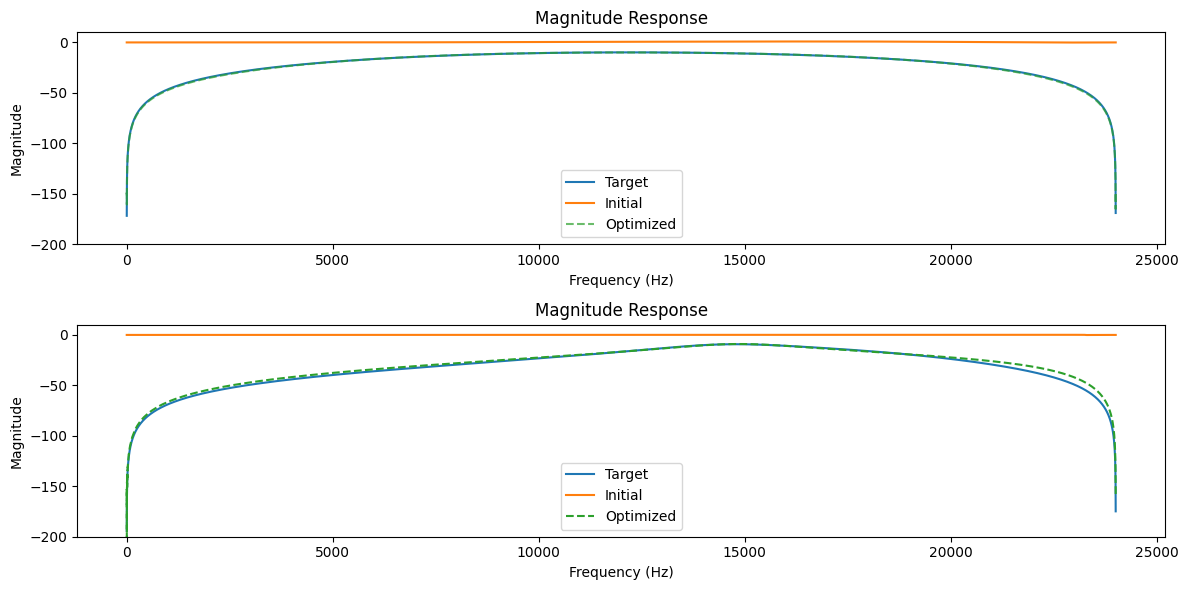

In [82]:
# Get optimized impulse response
with torch.no_grad():
    mag_optim = model.get_freq_response(identity=False, fs=fs).squeeze() 
    mag_optim = 20 * torch.log10(mag_optim)

freq_axis = torch.linspace(0, fs/2, nfft//2+1)

mag_target = 20 * torch.log10(torch.abs(target.squeeze()))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_axis, mag_target.squeeze()[...,0].numpy(), label='Target')
plt.plot(freq_axis, mag_init[...,0].numpy(), label='Initial')
plt.plot(freq_axis, mag_optim[...,0].numpy(), '--', label='Optimized', alpha=0.7)
plt.legend()
plt.ylim([-200, 10])
plt.title('Magnitude Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.subplot(2, 1, 2)
plt.plot(freq_axis, mag_target.squeeze()[...,1].numpy(), label='Target')
plt.plot(freq_axis, mag_init[...,1].numpy(), label='Initial')
plt.plot(freq_axis, mag_optim[...,1].numpy(), '--',label='Optimized')
plt.legend()
plt.ylim([-200, 10])
plt.title('Magnitude Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()